# Assignment 8

In this project, you will explore and analyze a public dataset of your choosing. Since this assignment is “open-ended” in nature, you are free to expand upon the requirements below. You may use a .ipynb file instead of .py.

You must add descriptions to each of the sections. You must explain what your code is doing (either in comments or via the supported HTML inside of a .ipynb file).

### Data Resources

• https://www.data.gov/

• https://opendata.cityofnewyork.us/

• https://datasetsearch.research.google.com/

• https://archive.ics.uci.edu/ml/index.php


In [419]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error


# I will be working with the housing data set available in kaggle

# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

# Training Set
df_train = pd.read_csv('https://raw.githubusercontent.com/igukusamuel/DATA-605-Final-Project/master/train.csv')

# Set the Id column to be the index
df_train.set_index(['Id'])

df_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Database Connection

##### (Optional Extra Credit)

Import the data you've selected into a SQL database of your choosing. Connect your database to Python.

### Resources:

https://dev.mysql.com/doc/workbench/en/wb-admin-export-import-table.html
https://medium.com/@tattwei46/how-to-use-python-with-mysql-79304bee8753
https://downloads.mysql.com/docs/connector-python-en.pdf
https://datatofish.com/how-to-connect-python-to-sql-server-using-pyodbc/


In [420]:
import mysql.connector

cnx = mysql.connector.connect(user='root', password='Sammiggy2030^', host='localhost', database='housingdata')
#print(cnx)

cursor = cnx.cursor()

sql = "SELECT Id FROM train"

cursor.execute(sql)

myresult = cursor.fetchall()

#print(len(myresult))

num = 0

for x in myresult:
    num = num + 1
    #print(x)
    #print(num)


#cnx.close

# Data Exploration (EDA)

Import your dataset into your python environment and explore your data. 
You should include any summary statistics, means, medians, quartiles, or any other relevant information about the dataset.


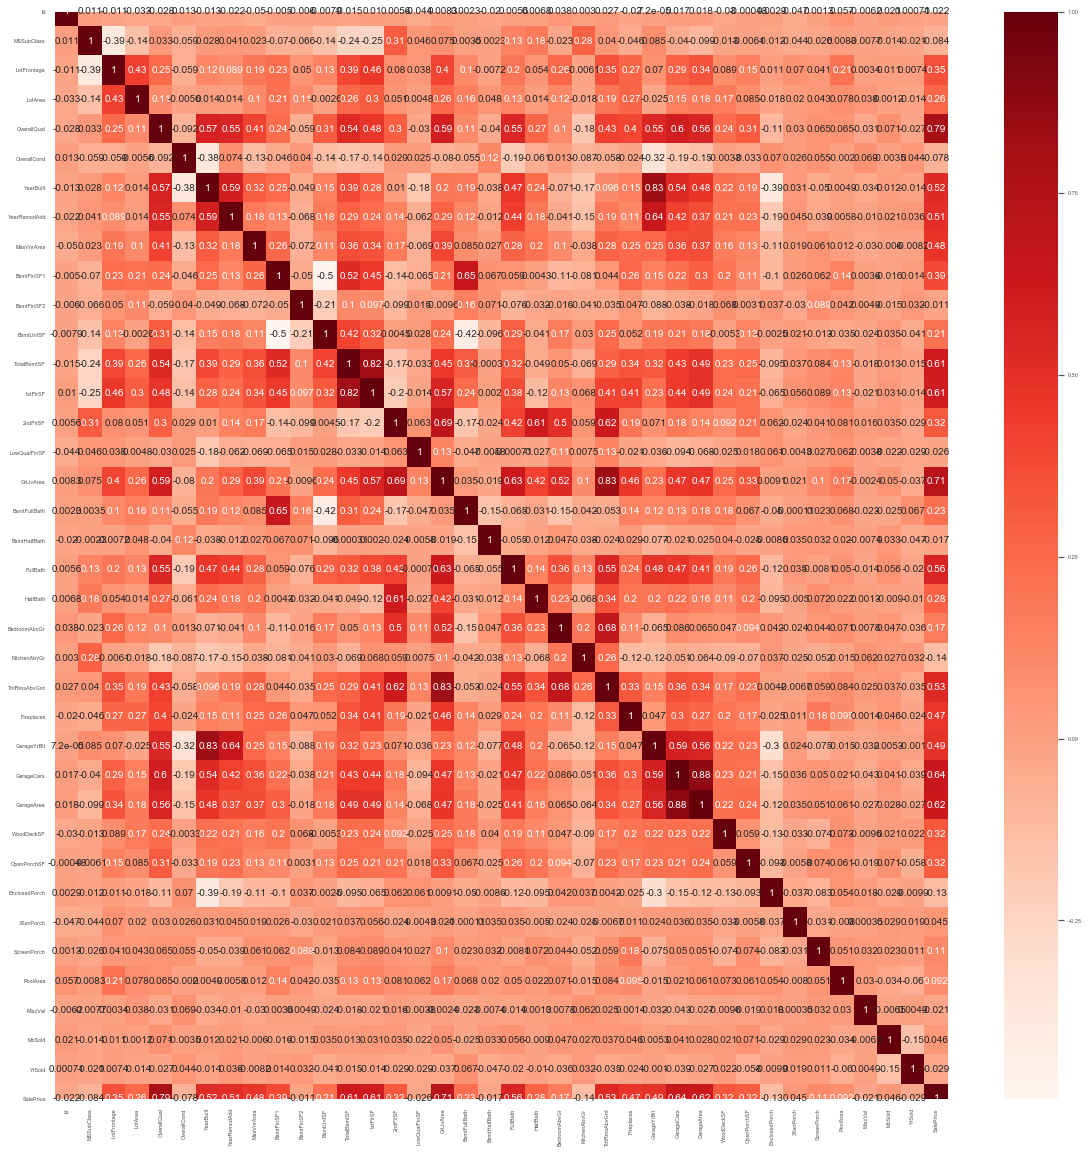

In [421]:
# We will perform summary statistics on a subset of the train data set from the housing data

# Uncomment the line below to view the no of columns and their respective data types
#df_train.info()

# The subset will be made up of only columns with numbers (This narrows down from 81 to 38 columns)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
sub_df_train = df_train.select_dtypes(include=numerics)

#Uncomment the line below to view the no of columns and the resulting data types
#sub_df_train.info()

# The code below outputs the count, mean, std, min, 1st, 2nd and 3rd quantiles and the max for each of the variables (columns)
#print(sub_df_train.describe().transpose())

# We create a corellation matrix to view the relationship between the different variables and select those with the greatest correlation for further analysis.
#print(sub_df_train.corr())

# Visualize the correlations graphically Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = sub_df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [422]:
# Correlation with output variable
target_cor = abs(cor['SalePrice'])

# Select only variables with highly correlated features ie. those above 0.40
desired_features = target_cor[target_cor > 0.40]
print(desired_features)

# Create a data frame with only these desired features for further analysis
df_rel = sub_df_train[['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
                      'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice']]

df_rel.head()

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64


,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
0,7,2003,2003,196.0,856,856,1710,2,8,0,2003.0,2,548,208500
1,6,1976,1976,0.0,1262,1262,1262,2,6,1,1976.0,2,460,181500
2,7,2001,2002,162.0,920,920,1786,2,6,1,2001.0,2,608,223500
3,7,1915,1970,0.0,756,961,1717,1,7,1,1998.0,3,642,140000
4,8,2000,2000,350.0,1145,1145,2198,2,9,1,2000.0,3,836,250000


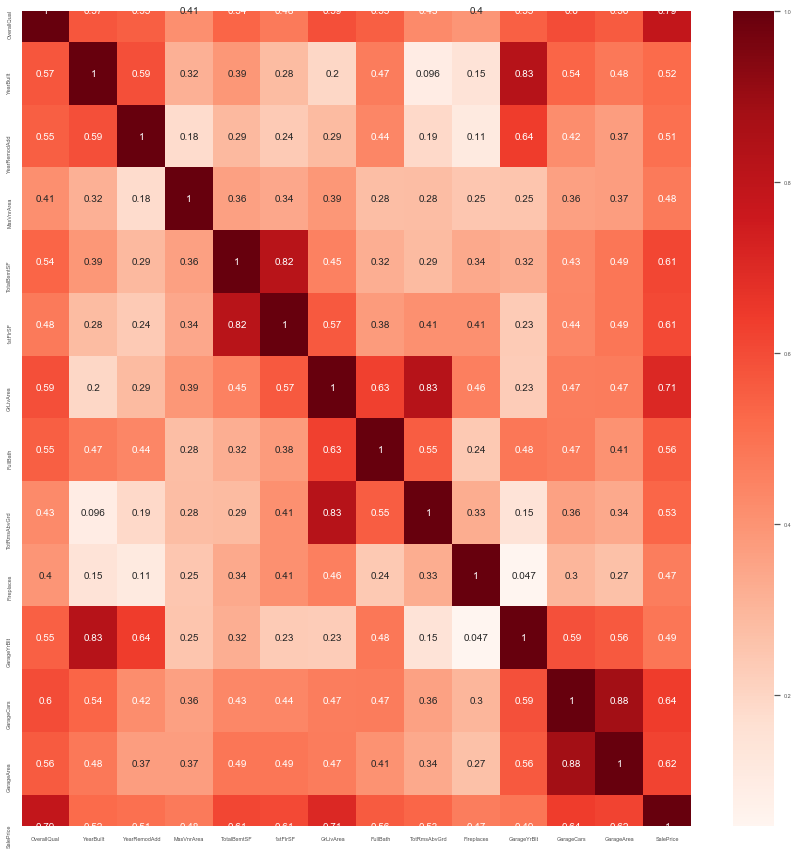

In [423]:
# We create a corellation matrix to view the relationship between the selected variables with the greatest correlation.
#print(sub_df_train.corr())

# Visualize the correlation coefficient of the selected variables
plt.figure(figsize=(15,15))
cor = df_rel.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Data Wrangling/Cleaning

Please perform some basic transformations/data manipulations.

### Resources:

https://pandas.pydata.org/docs/user_guide/index.html


In [424]:
# We are going to perform various transformation on the data

# Create a copy of the data frame
df = df_rel

# Perform a check of whether any of the values are missing
print('Is there missing values: ', df.isnull().values.any()) # True if there are missing values and False if not.
print(df.isnull().sum()) # To output total missing values per column (MasVnrArea - 8NA's, GarageYrBlt - 81NA's)
print('Total missing values: ', df.isnull().sum().sum()) # To put put total missing values

# Replace all the NA's with 0 for the columns (LotFrontage , MasVnrArea, GarageYrBlt) with missing data in the df dataframe
df1 = df.fillna(0)
print('Missing values after replacing all NAs with 0: ', df1.isnull().sum().sum()) # To put put total missing values


Is there missing values:  True
OverallQual      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       8
TotalBsmtSF      0
1stFlrSF         0
GrLivArea        0
FullBath         0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt     81
GarageCars       0
GarageArea       0
SalePrice        0
dtype: int64
Total missing values:  89
Missing values after replacing all NAs with 0:  0


# Data Visualizations

Include supporting data visualizations here. 
You may use any visualization library of your choice. 
You must explain what each visualization is showing.

### Resources:

https://plotly.com/python/plotly-express/
https://seaborn.pydata.org/introduction.html
https://matplotlib.org/
    

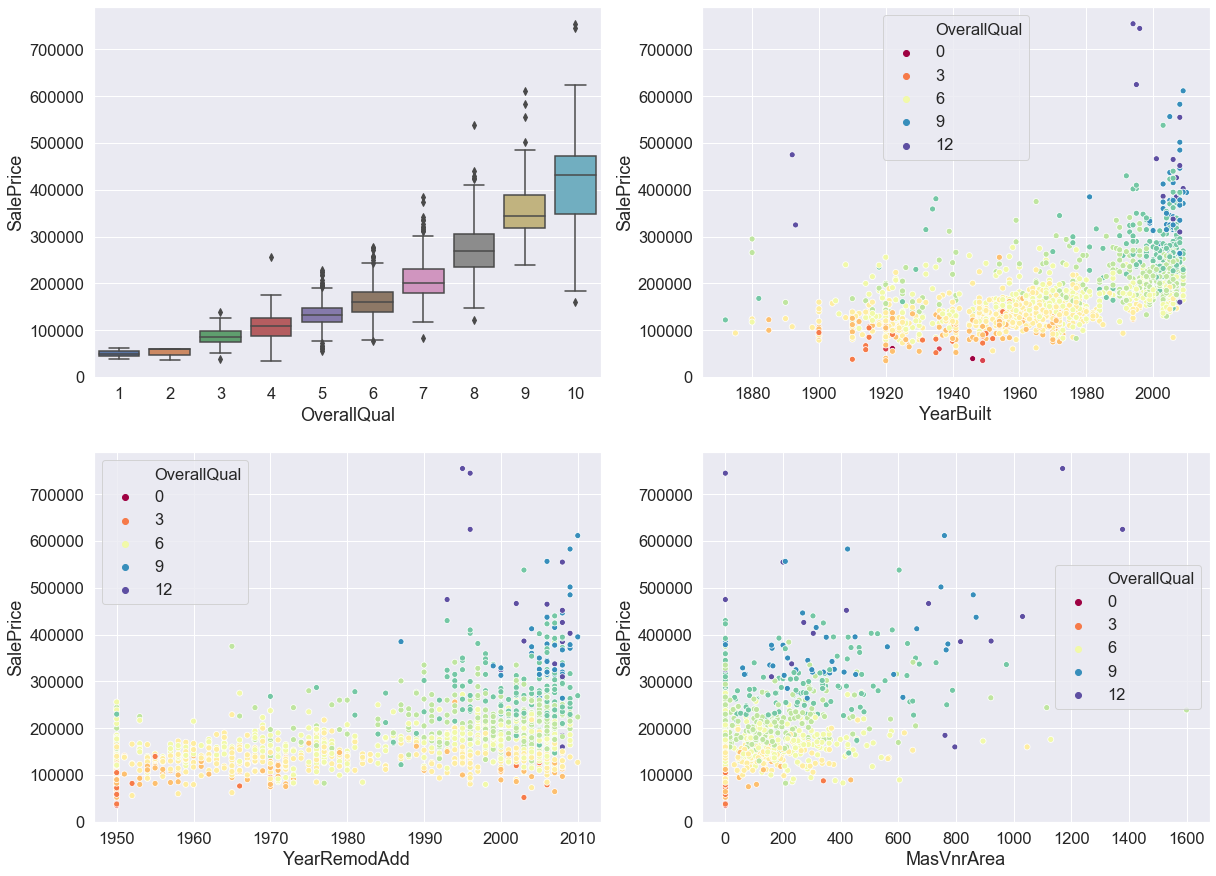

In [425]:
'''
I have included a boxplot visualization for OverallQual

Visualize "OverallQual", "YearBuilt", "YearRemodAdd", "MasVnrArea" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice
'''
train = df_train
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig1 = fig.add_subplot(221)
sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.YearBuilt, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig3 = fig.add_subplot(223); 
sns.scatterplot(x = train.YearRemodAdd, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train.MasVnrArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')


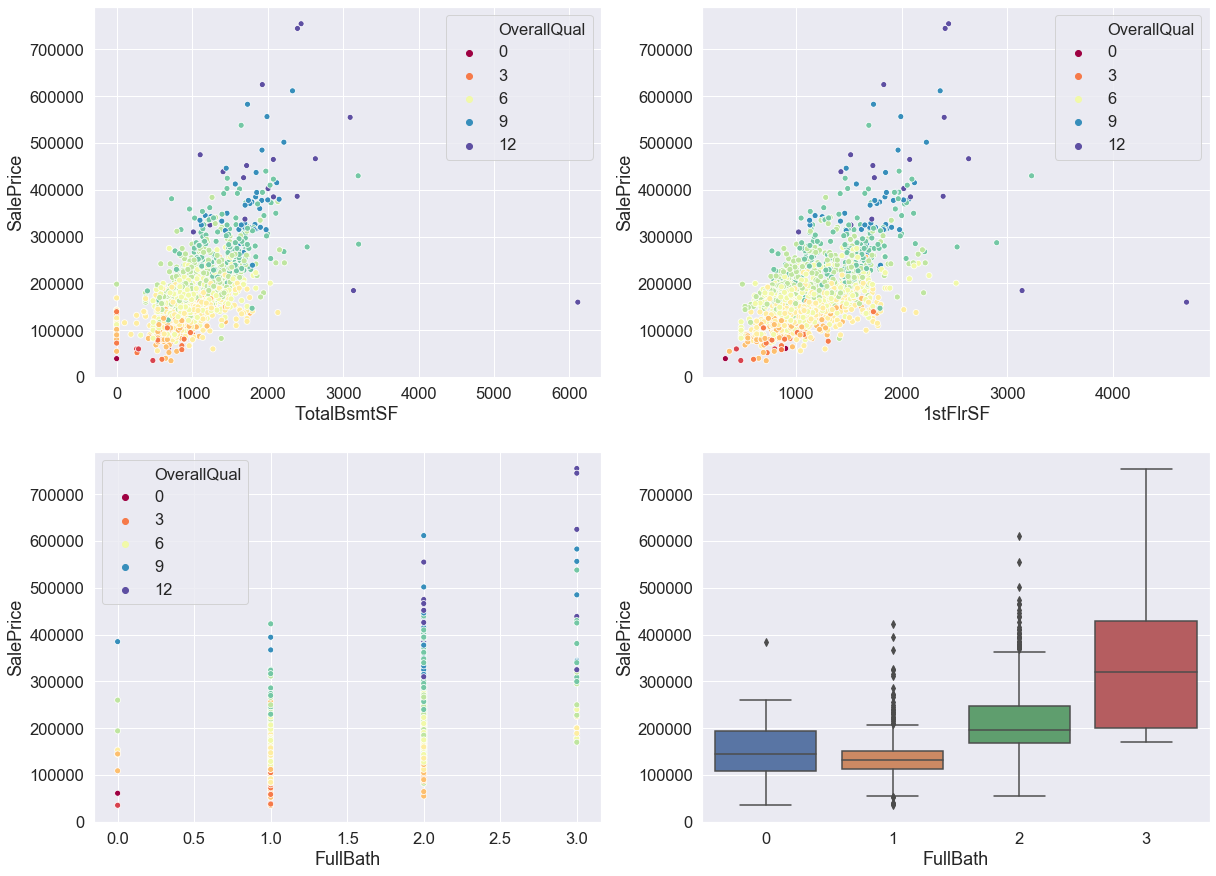

In [426]:
'''
Visualize "TotalBsmtSF", "1stFlrSF", "FullBath" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice

I have included a boxplot visualization for FullBath
'''

fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig5 = fig.add_subplot(221); 
sns.scatterplot(x = train.TotalBsmtSF, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig6 = fig.add_subplot(222); 
sns.scatterplot(x = train['1stFlrSF'], y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig8 = fig.add_subplot(223); 
sns.scatterplot(x = train.FullBath, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig8_1 = fig.add_subplot(224); 
sns.boxplot(x='FullBath', y='SalePrice', data=train[['SalePrice', 'FullBath']])


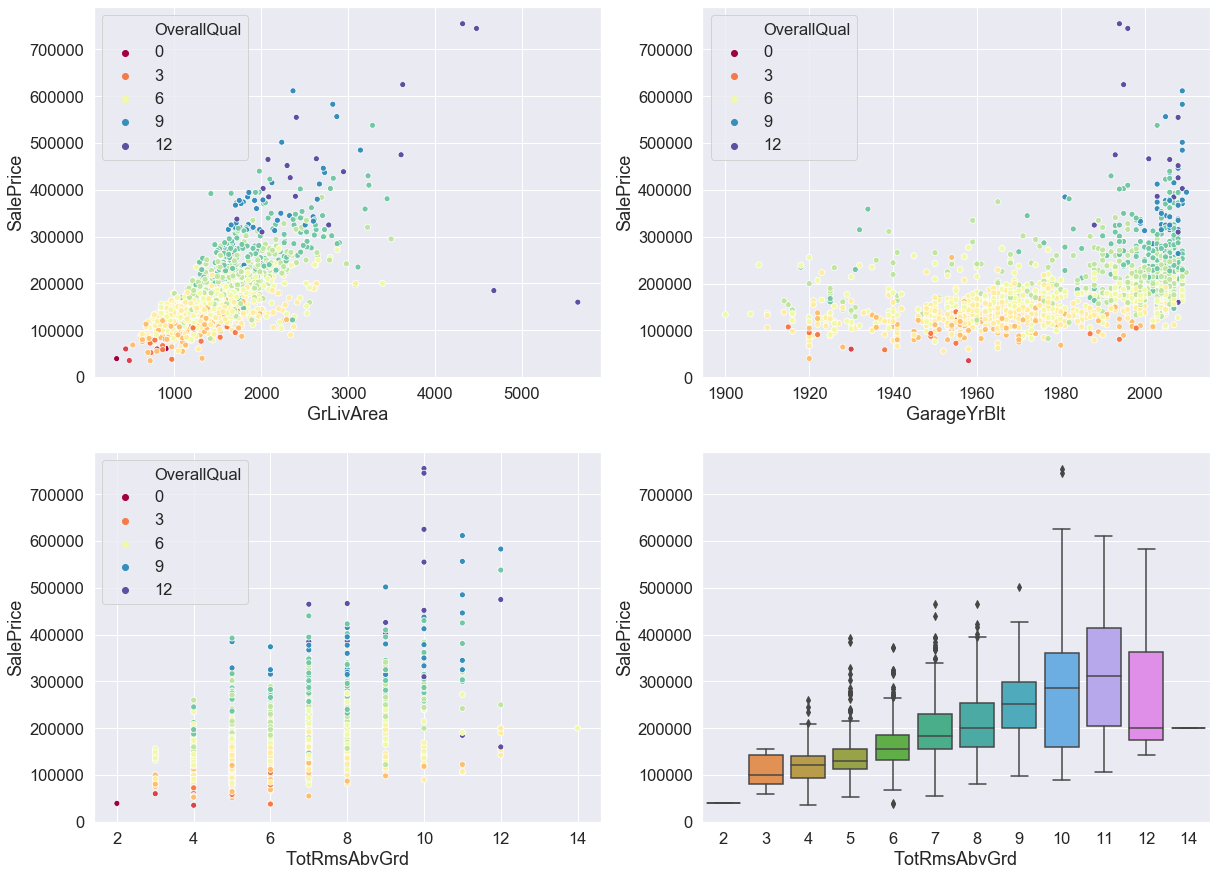

In [427]:
'''
Visualize "GrLivArea", "TotRmsAbvGrd","GarageYrBlt" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice

I have included a boxplot visualization for TotRmsAbvGrd
'''
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig7 = fig.add_subplot(221); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig10 = fig.add_subplot(222); 
sns.scatterplot(x = train.GarageYrBlt, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig9 = fig.add_subplot(223); 
sns.scatterplot(x = train.TotRmsAbvGrd, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig9_1 = fig.add_subplot(224); 
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=train[['SalePrice', 'TotRmsAbvGrd']])


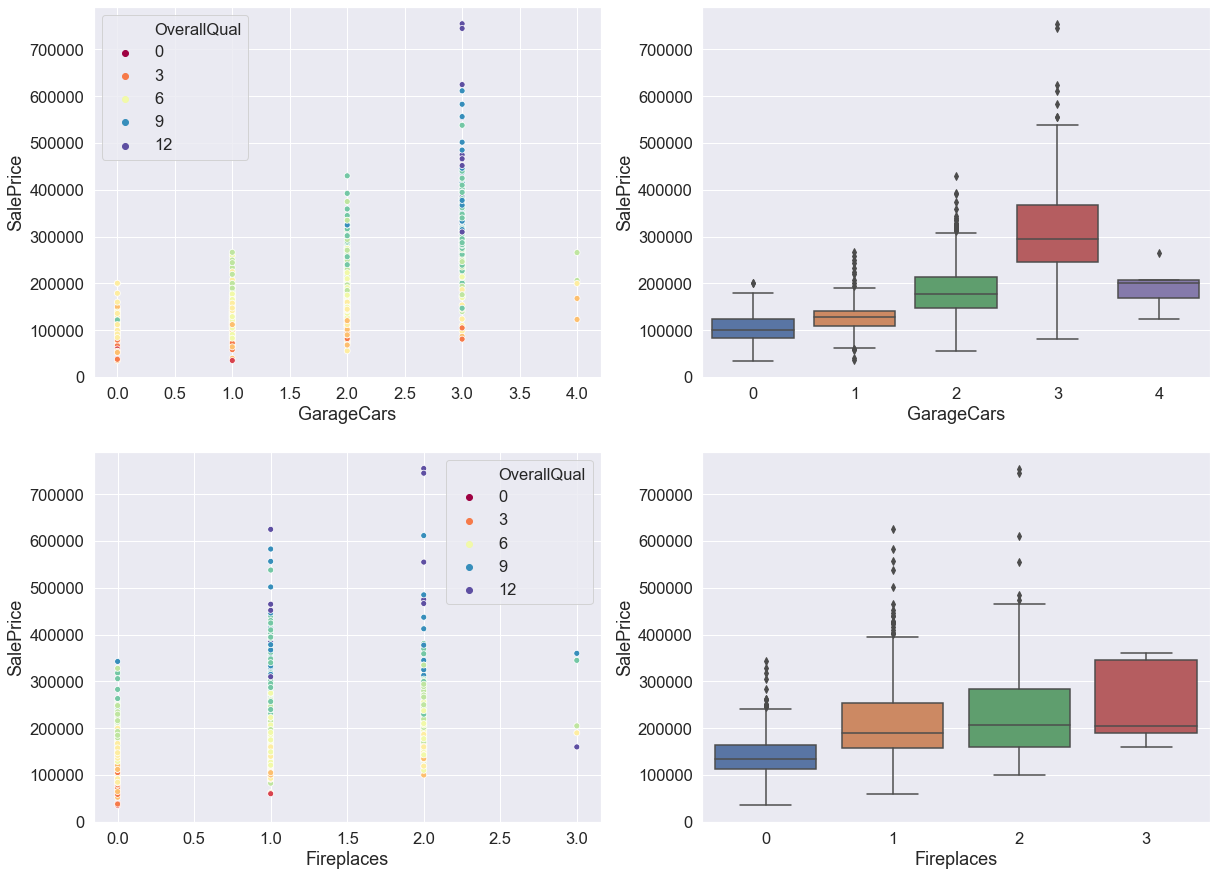

In [428]:
'''
Visualize "GarageCars", "Fireplaces" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice

I have included a boxplot visualization for GarageCars and FirePlaces as well
'''

fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig12 = fig.add_subplot(221); 
sns.scatterplot(x = train.GarageCars, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig12_1 = fig.add_subplot(222);
sns.boxplot(x='GarageCars', y='SalePrice', data=train[['SalePrice', 'GarageCars']])

fig9 = fig.add_subplot(223); 
sns.scatterplot(x = train.Fireplaces, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig9_1 = fig.add_subplot(224);
sns.boxplot(x='Fireplaces', y='SalePrice', data=train[['SalePrice', 'Fireplaces']])

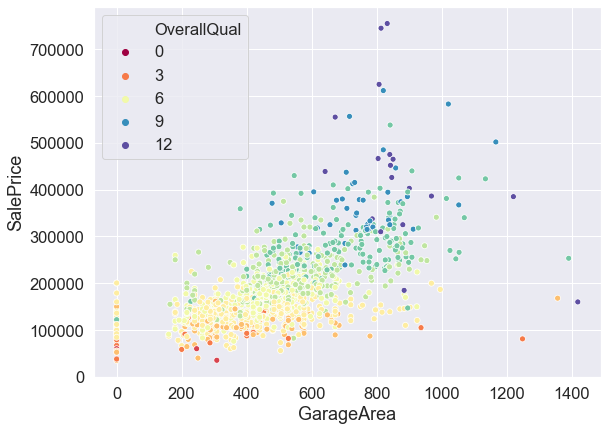

In [429]:
''' 
Visualize "GarageArea" to the "SalePrice"
compare how they relate with 'OverallQual'- Overrall Quality which has the highest correlation to SalePrice
'''
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

fig11 = fig.add_subplot(223); 
sns.scatterplot(x = train.GarageArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

AxesSubplot(0.125,0.125;0.775x0.755)


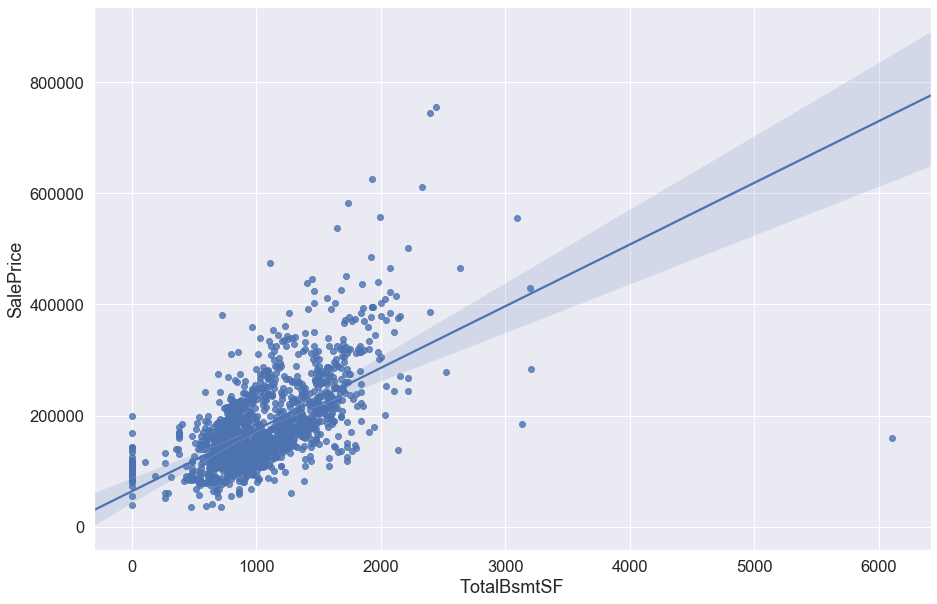

In [430]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='TotalBsmtSF', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


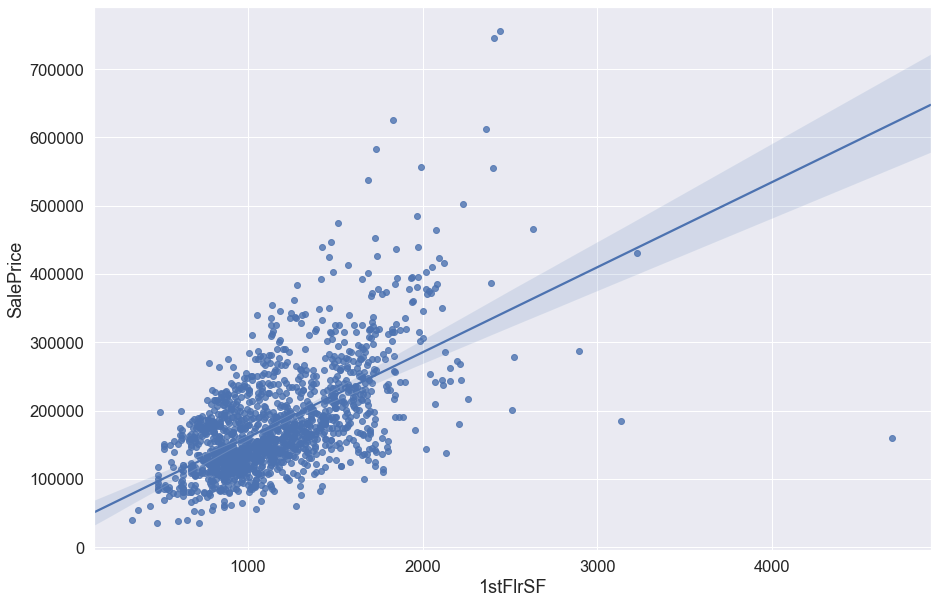

In [431]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='1stFlrSF', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


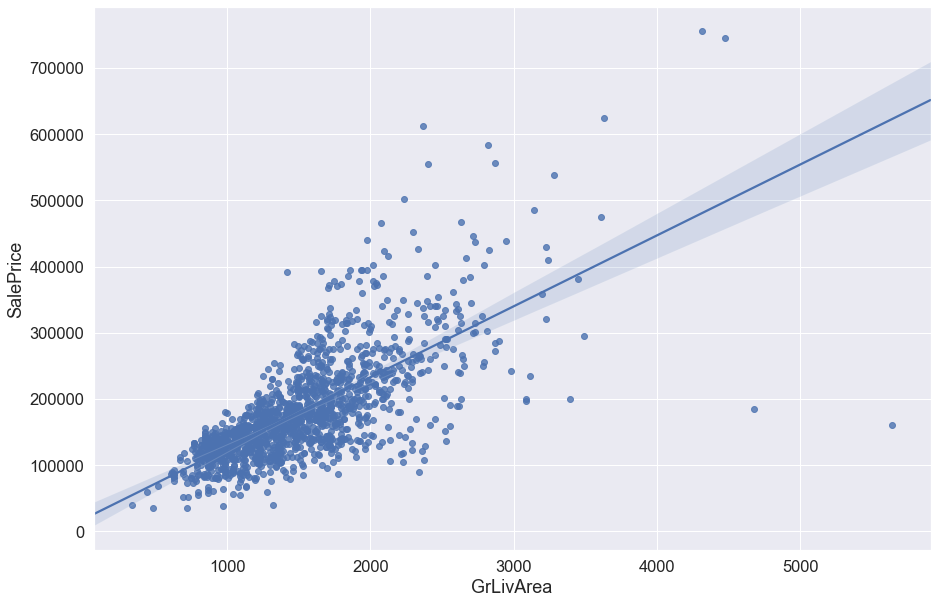

In [432]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='GrLivArea', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


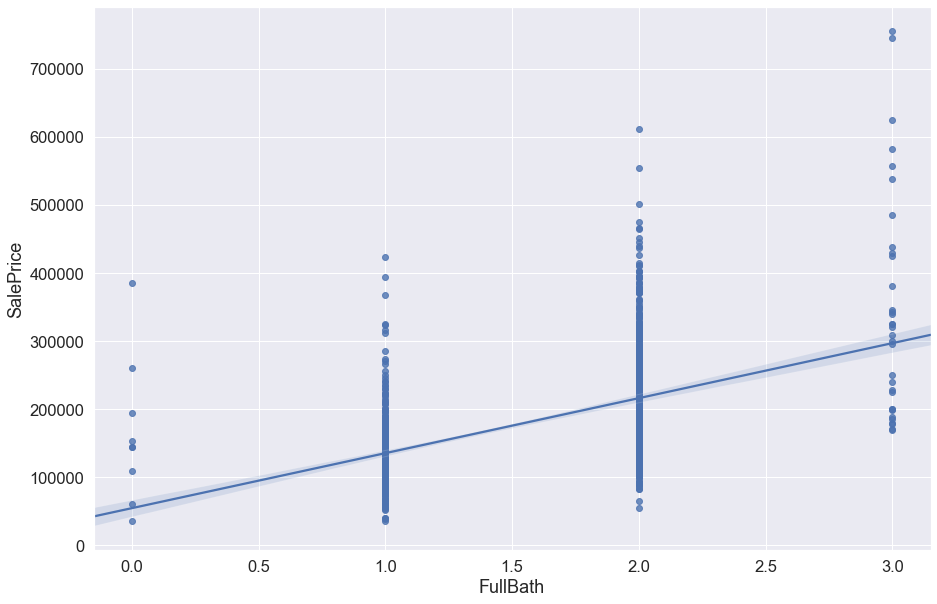

In [433]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='FullBath', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


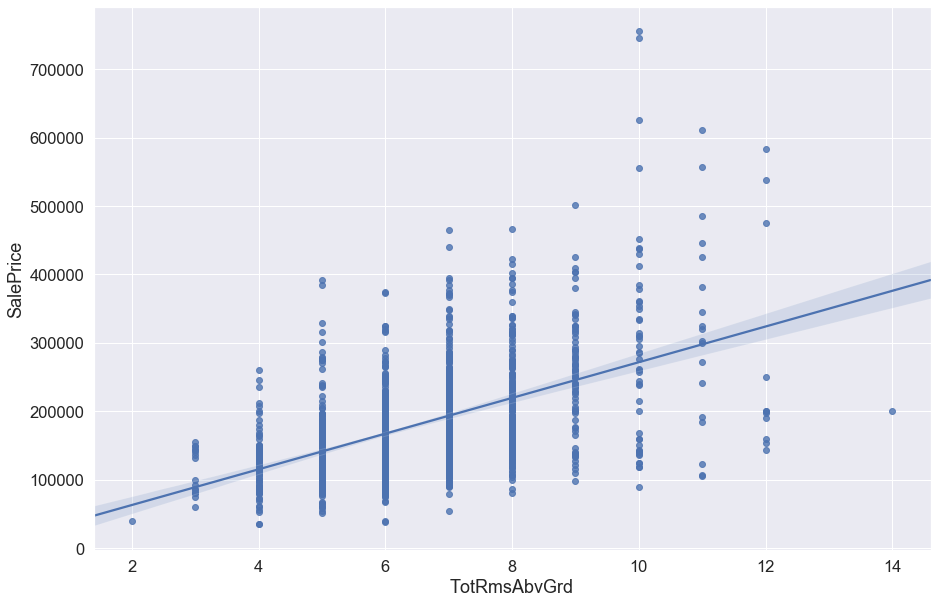

In [434]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='TotRmsAbvGrd', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


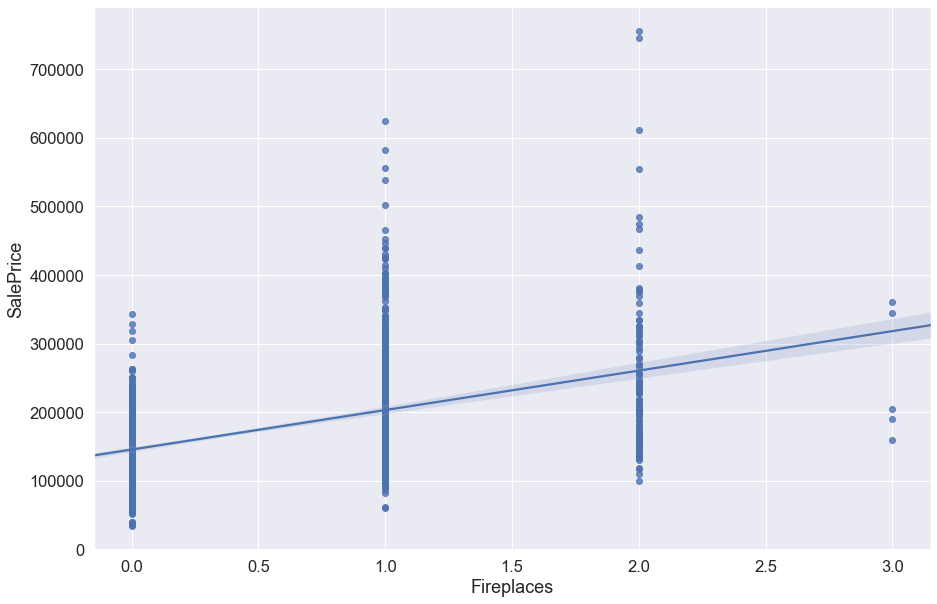

In [435]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='Fireplaces', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


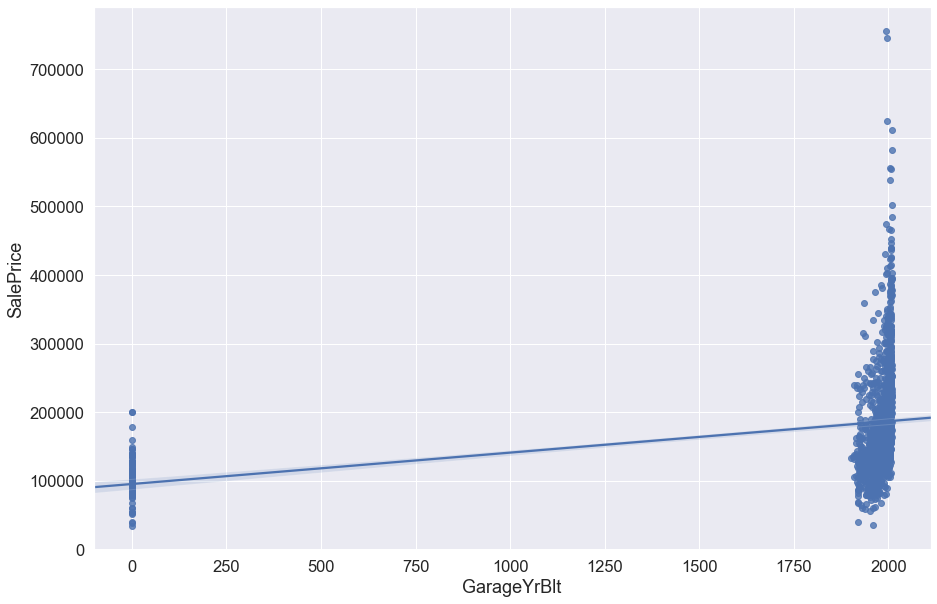

In [436]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='GarageYrBlt', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


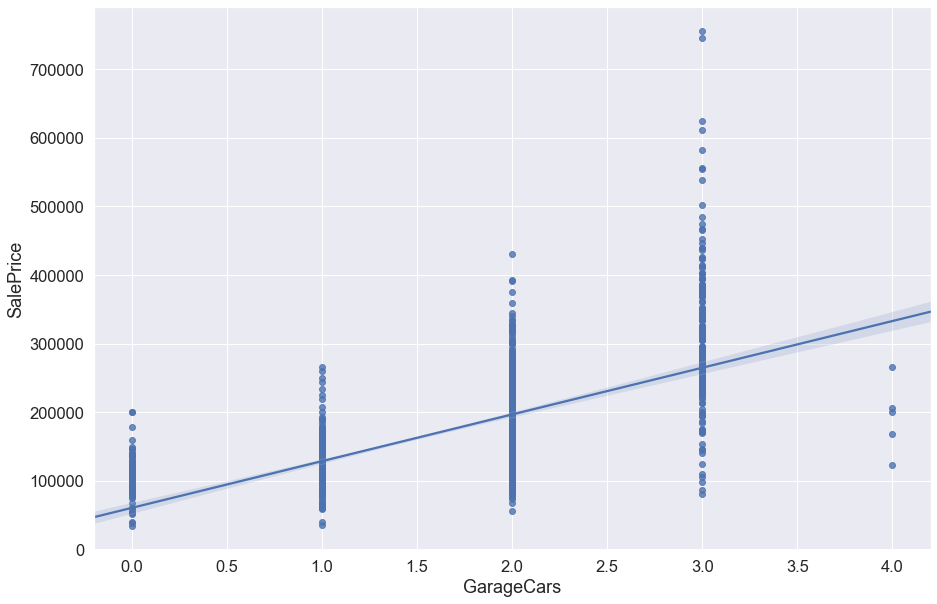

In [437]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='GarageCars', y='SalePrice', data=df1, ax=ax))


AxesSubplot(0.125,0.125;0.775x0.755)


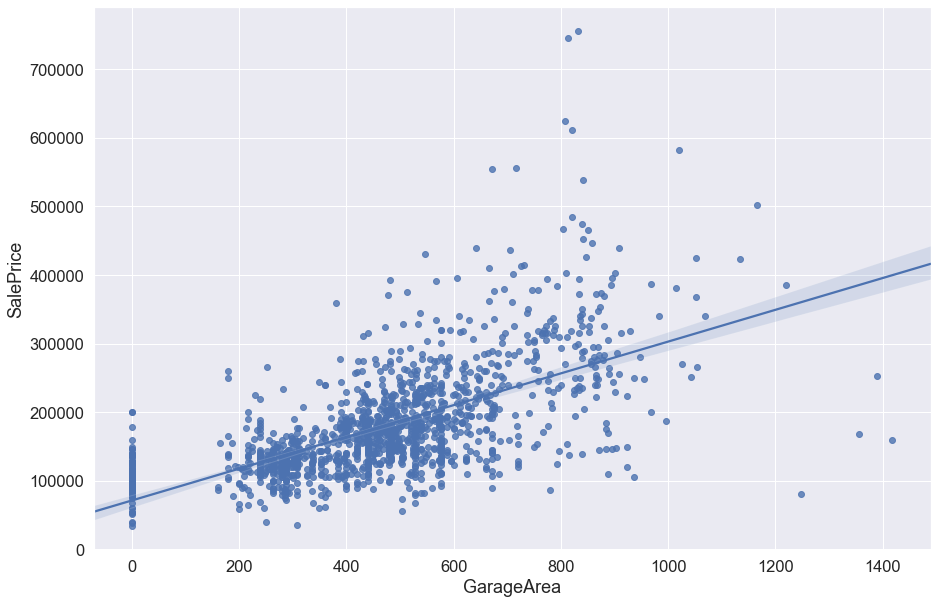

In [438]:
f, ax = plt.subplots(figsize=(15, 10))

print(sns.regplot(x='GarageArea', y='SalePrice', data=df1, ax=ax))

# Machine Learning

##### (Optional Extra Credit)

Perform some machine learning on your manipulated data. You may use any ML algorithm you think would work on your data.

### Resources:

https://www.datacamp.com/community/tutorials/machine-learning-python
https://scikit-learn.org/stable/
    

In [439]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing



# We will use scikit-learn module
# Load training data set from the Kaggle website housing data competition
train = pd.read_csv('https://raw.githubusercontent.com/igukusamuel/DATA-605-Final-Project/master/train.csv')

# Load testing data set
test = pd.read_csv('https://raw.githubusercontent.com/igukusamuel/DATA-605-Final-Project/master/test.csv')

# Drop Id columns in both train and test sets since its not necessary
train_Id = train['Id']
train.drop('Id', axis=1, inplace=True)

test_Id = test['Id']
test.drop('Id', axis=1, inplace=True)

# Add a saleprice column into the test data set with zero values
test['SalePrice'] = 0

# Combine the two data sets and perform data clean up
data = pd.concat((train, test)).reset_index(drop=True)

# Perform a check of missing values
print('Is there missing values: ', data.isnull().values.any()) # True if there are missing values and False if not.

print(data.isnull().sum()) # To output total missing values per column (MasVnrArea - 8NA's, GarageYrBlt - 81NA's)

print('Total missing values: ', data.isnull().sum().sum()) # To put put total missing values


# Replace all the NA's with 0 for the columns (LotFrontage , MasVnrArea, GarageYrBlt) with missing data in the df dataframe
#data = data.fillna(0)

#Check for missing values after the replacement of NAs with 0
#print('Missing values after replacing all NAs with 0: ', data.isnull().sum().sum())


Is there missing values:  True
MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64
Total missing values:  13965


In [440]:
# Building a mapping scheme to transform the ordinal features and preserving its significance:
# Code from: https://www.kaggle.com/mgmarques/houses-prices-complete-solution
data_transf = data

def map_ordinals(data):
    
    # LandSlope: Slope of property
    LandSlope = {}
    LandSlope['Gtl'] = 3 #'Gentle slope'
    LandSlope['Mod'] = 2 #'Moderate Slope'
    LandSlope['Sev'] = 1 #'Severe Slope'

    data.LandSlope = data.LandSlope.map(LandSlope)
        
    # ExterQual: Evaluates the quality of the material on the exterior 
    ExterQual = {}
    ExterQual['Ex'] = 5 #'Excellent'
    ExterQual['Gd'] = 4 #'Good'
    ExterQual['TA'] = 3 #'Average/Typical'
    ExterQual['Fa'] = 2 #'Fair'
    ExterQual['Po'] = 1 #'Poor'
    ExterQual['NA'] = 0 #'NA'

    data.ExterQual = data.ExterQual.map(ExterQual)

    # ExterCond: Evaluates the present condition of the material on the exterior
    data.ExterCond = data.ExterCond.map(ExterQual)

    #HeatingQC: Heating quality and condition
    data.HeatingQC = data.HeatingQC.map(ExterQual)

    # KitchenQual: Kitchen quality
    data.KitchenQual = data.KitchenQual.map(ExterQual)

    # FireplaceQu: Fireplace quality
    data.FireplaceQu = data.FireplaceQu.map(ExterQual)

    # GarageCond: Garage Conditionals
    data.GarageCond = data.GarageCond.map(ExterQual)

    PavedDrive = {}
    PavedDrive['Y'] = 3 #'Paved'
    PavedDrive['P'] = 2 #'Partial Pavement'
    PavedDrive['N'] = 1 #'Dirt/Gravel'

    data.PavedDrive = data.PavedDrive.map(PavedDrive)

    # LotShape: General shape of property
    LotShape = {}
    LotShape['Reg'] = 4 #'Regular'
    LotShape['IR1'] = 3 #'Slightly irregular'
    LotShape['IR2'] = 2 #'Moderately Irregular'
    LotShape['IR3'] = 1 #'Irregular'

    data.LotShape = data.LotShape.map(LotShape)

    # BsmtQual: Evaluates the height of the basement
    BsmtQual = {}
    BsmtQual['Ex'] = 5 #'Excellent (100+ inches)'
    BsmtQual['Gd'] = 4 #'Good (90-99 inches)'
    BsmtQual['TA'] = 3 #'Typical (80-89 inches)'
    BsmtQual['Fa'] = 2 #'Fair (70-79 inches)'
    BsmtQual['Po'] = 1 #'Poor (<70 inches'
    BsmtQual['NA'] = 0 #'No Basement'

    data.BsmtQual = data.BsmtQual.map(BsmtQual)

    # BsmtCond: Evaluates the general condition of the basement
    data.BsmtCond = data.BsmtCond.map(BsmtQual)

    # GarageQual: Garage quality
    data.GarageQual = data.GarageQual.map(BsmtQual)

    # PoolQC: Pool quality
    data.PoolQC = data.PoolQC.map(BsmtQual)
    
    # BsmtExposure: Refers to walkout or garden level walls
    BsmtExposure = {}
    BsmtExposure['Gd'] = 4 #'Good Exposure'
    BsmtExposure['Av'] = 3 #'Average Exposure (split levels or foyers typically score average or above)'
    BsmtExposure['Mn'] = 2 #'Mimimum Exposure'
    BsmtExposure['No'] = 1 #'No Exposure'
    BsmtExposure['NA'] = 0 #'No Basement'

    data.BsmtExposure = data.BsmtExposure.map(BsmtExposure)

    # BsmtFinType1: Rating of basement finished area
    BsmtFinType1 = {}
    BsmtFinType1['GLQ'] = 6 #'Good Living Quarters'
    BsmtFinType1['ALQ'] = 5 # 'Average Living Quarters'
    BsmtFinType1['BLQ'] = 4 # 'Below Average Living Quarters'
    BsmtFinType1['Rec'] = 3 # 'Average Rec Room'
    BsmtFinType1['LwQ'] = 2 # 'Low Quality'
    BsmtFinType1['Unf'] = 1 # 'Unfinshed'
    BsmtFinType1['NA'] = 0 #'No Basement'

    data.BsmtFinType1 = data.BsmtFinType1.map(BsmtFinType1)

    # BsmtFinType2: Rating of basement finished area (if multiple types)
    data.BsmtFinType2 = data.BsmtFinType2.map(BsmtFinType1)

    #CentralAir: Central air conditioning
    # Since with this transformatio as the same as binarize this feature
    CentralAir = {}
    CentralAir['N'] = 0
    CentralAir['Y'] = 1

    data.CentralAir = data.CentralAir.map(CentralAir)

    # GarageFinish: Interior finish of the garage
    GarageFinish = {}
    GarageFinish['Fin'] = 3 #'Finished'
    GarageFinish['RFn'] = 2 #'Rough Finished'
    GarageFinish['Unf'] = 1 #'Unfinished'
    GarageFinish['NA'] = 0 #'No Garage'
    
    data.GarageFinish = data.GarageFinish.map(GarageFinish)
    
    # Functional: Home functionality
    Functional = {}
    Functional['Typ'] = 7   # Typical Functionality
    Functional['Min1'] = 6  # Minor Deductions 1
    Functional['Min2'] = 5  # Minor Deductions 2
    Functional['Mod'] = 4   # Moderate Deductions
    Functional['Maj1'] = 3  # Major Deductions 1
    Functional['Maj2'] = 2  # Major Deductions 2
    Functional['Sev'] = 1   # Severely Damaged
    Functional['Sal'] = 0   # Salvage only

    data.Functional = data.Functional.map(Functional)
    
    #Street: Type of road access to property
    # Since with this transformatio as the same as binarize this feature
    Street = {}
    Street['Grvl'] = 0 # Gravel 
    Street['Pave'] = 1 # Paved

    data.Street = data.Street.map(Street)


    # Fence: Fence quality
    Fence = {}
    Fence['GdPrv'] = 5 #'Good Privacy'
    Fence['MnPrv'] = 4 #'Minimum Privacy'
    Fence['GdWo'] = 3 #'Good Wood'
    Fence['MnWw'] = 2 #'Minimum Wood/Wire'
    Fence['NA'] = 1 #'No Fence'

    data.Fence = data.Fence.map(Fence)
    #But No Fence has the higest median Sales Price. So I try to use it as categorical
            
    return data

new_data = map_ordinals(data_transf)

# Replace all the NA's with 0 for the columns (LotFrontage , MasVnrArea, GarageYrBlt) with missing data in the df dataframe
#new_data = new_data.fillna(0)



In [441]:
data_dum = new_data

# Code from: https://www.kaggle.com/mgmarques/houses-prices-complete-solution

def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(len(categorical_cols), "categorical columns")
    print(categorical_cols)
    # Remove special charactres and withe spaces. 
    for col in categorical_cols:
        df[col] = df[col].str.replace('\W', '').str.replace(' ', '_') #.str.lower()

    dummies = pd.get_dummies(df[categorical_cols], columns = categorical_cols).columns
    df = pd.get_dummies(df, columns = categorical_cols)

    print("Total Columns:",len(df.columns))
    print(df.info())
    
    return df, dummies

# Correct Categorical from int to str types
data_dum.MSSubClass = data_dum.MSSubClass.astype('str')
data_dum.MoSold = data_dum.MoSold.astype('str')

data_dum, dummies = one_hot_encode(data_dum)

#data_dum.to_csv('Output.csv')


24 categorical columns
Index(['MSSubClass', 'MSZoning', 'Alley', 'LandContour', 'Utilities',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
       'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')
Total Columns: 248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 248 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(24), int64(32), uint8(192)
memory usage: 1.8 MB
None


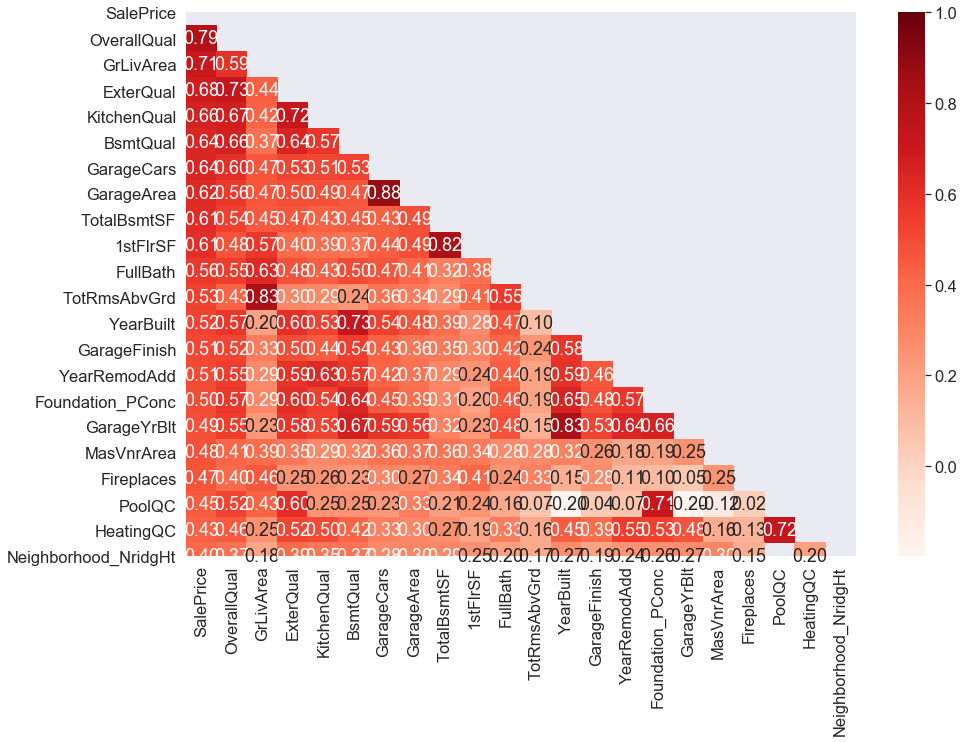

In [442]:
# Visualize the correlation coefficient of all variables including the dummies
corr = data_dum[data_dum.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.40)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(15, 10))
#sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
#sns.set(font_scale=0.5)

sns.heatmap(top_corr, annot=True, cmap=plt.cm.Reds, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.show()

In [443]:
#for col in data_dum.columns:
#    print(col)

cols = data_dum.columns 
#print(cols)

for c in cols:
    if data_dum[c].dtype == 'uint8':
        data_dum[c] = data_dum[c].astype('category')
        
        
numeric_features = list(data_dum.loc[:, cols].dtypes[(data_dum.dtypes != "category") & (data_dum.dtypes !='uint8')].index)

print(numeric_features)

['LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'YrSold', 'SalePrice']


In [463]:
# Correlation with output variable
cor = data_dum[data_dum.SalePrice>1].corr()
target_cor = abs(cor['SalePrice'])

# Select only variables with highly correlated features ie. those above 0.4
desired_features = target_cor[target_cor > 0.3]
print(desired_features)
print(len(desired_features))


final_data = data_dum[["OverallQual", "YearBuilt", "YearRemodAdd", "MasVnrArea", "ExterQual", "BsmtQual", 
                      "TotalBsmtSF", "HeatingQC", "1stFlrSF", "GrLivArea", "FullBath", "KitchenQual", 
                      "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", 
                      "LotFrontage", "BsmtExposure", "BsmtFinSF1", "2ndFlrSF", "WoodDeckSF",
                      "OpenPorchSF", "SalePrice"]] 

#print(final_data.head())

LotFrontage     0.351799
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
ExterQual       0.682639
BsmtQual        0.644019
BsmtExposure    0.352958
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
HeatingQC       0.427649
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
KitchenQual     0.659600
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageFinish    0.513105
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
PoolQC          0.447936
SalePrice       1.000000
Name: SalePrice, dtype: float64
26
   OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  BsmtQual  \
0            7       2003          2003       196.0          4       4.0   
1            6       1976          1976         0.0          3       4.0   
2            7       2001          2002       162.0          4       4.0   
3          

In [464]:
# splitting the dataset into the source variables (independant variables) and the target variable (dependant variable)
# indp_vars = dataset.loc[:, dataset.columns != 'SalePrice'].values
# all_data = final_data
all_data = final_data.select_dtypes(include=[np.number]).interpolate().dropna()

train_d = all_data.loc[(all_data.SalePrice>0)].reset_index(drop=True, inplace=False)
#print(train_d.info())
print(sum(train_d.isnull().sum() != 0))

test_data = all_data.loc[(all_data.SalePrice==0)].reset_index(drop=True, inplace=False)
test_d = test_data.drop(['SalePrice'], axis=1)

indp_vars = train_d.drop(['SalePrice'], axis=1)
target_var = train_d['SalePrice']

#print(indp_vars.head())

X = indp_vars
y = target_var


0


0.7536286648937035


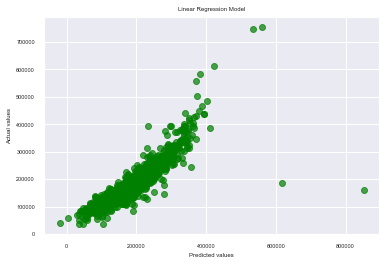

In [465]:
#Split data into train test set using the train_test_split() function in scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21, test_size = 0.8)

# Create a linear Regresion model
logreg = LinearRegression()

# Fit the Model to the training set
model = logreg.fit(X_train, y_train)

#Evaluate the performance  of the model
print(model.score(X_test, y_test))  

# Use the model to predict
predictions = model.predict(X_test)

# Find the mean squared error of the predicted values
#print(mean_squared_error(y_test, predictions))

# Graphically visualize the relationship between the predicted and the actual values
actual = y_test
plt.scatter(predictions, actual, alpha=.7, color='green') # Use alpha to show overlapping data
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Linear Regression Model')
plt.show()


In [467]:
# The Kaggle website requires a submission of the final result

# Create a kaggle dataframe and append test id from the test data
kaggle_submission = pd.DataFrame()
kaggle_submission['Id'] = test_Id

# Kaggle test data, not included in the training and testing sets in the previous section
submission_test = test_d

# Use the prediction model above to predict the SalePrice of the kaggle test data
kaggle_prediction = model.predict(test_d)

# Append the SalePrice column to the kaggle dataframe
kaggle_submission['SalePrice'] = kaggle_prediction

print(kaggle_submission.head())

# Write final submission into a csv file
kaggle_submission.to_csv('kaggle_submission.csv', index = False)


     Id      SalePrice
0  1461   99829.495590
1  1462  177174.773929
2  1463  177702.372146
3  1464  191926.217570
4  1465  189726.953166


In [ ]:
![title](https://github.com/igukusamuel/DATA-602-Python-Assignments/blob/master/Kaggle_SubmissionFinal.png)

# Conclusions

Provide some conclusions or insight gained from looking at your data.
